# Baseball Hall of Fame Classifier Project

CS3315 <br>
Theodore Falk <br>
Spyridon Tassopoulos <br>
Onur Buyuksutcu <br>
Repo Link: https://gitlab.nps.edu/cs3315/sp24/cs3315_lahman_baseball

If you have ever lisen to sports talk radio you know just how much people love to argue about who belongs in the various sports Hall of Fames. This is espically true for baseball, where the Hall of Fame in Cooperstown, NY has a rich history being founded in 1939. It is considered the ultimate honor to be enshrined amoung the games best. One such player under consideration is Chase Utley, who for about a decade was considered the best second baseman in baseball. On his first year on the ballot he recieved 28.8% of the vote (75% is needed for induction). Players vote totals typically increase on future votes, so the question is will it increase enough?

The goal of this project was to see if we could use machine learning to come up with a model that could accurate predict which players should be inducted based on the stats based on the their career statistics, and apply it to borderline players, such as Utley.

To do so we will utilized the Lahamn database, which includes a collection of CSV files containing the batting, pitching, fielding, awards, salary statistics of over a hundred years of Major Leauge Baseball history. The full database is avaible at: http://www.seanlahman.com/

To begin we will import the Hall of Fame data as a Pandas dataframe.

In [1]:
import pandas as pd
import baseball_helper_functions as bhf
pd.options.display.max_rows = 100000

#Create a data frame of successful Hall of Fame Players
df_hof = pd.read_csv('./lahman_1871-2023_csv/HallOfFame.csv')
#Narrow the list to only players (remove managers, executives, etc.)
df_elected = df_hof.query("inducted == 'Y' and category == 'Player' and needed_note != 'Preliminary poll'")
#Merging the Hall of Famers with there biographic info for readability
df_bio = pd.read_csv('./lahman_1871-2023_csv/People.csv', encoding='latin-1')
df_elected = pd.merge(df_elected, df_bio, on='playerID')

Next we need to split our Hall of Famers into players who were pitchers and batters, to do so we will set a Innings Pitched threshold to seperate the Hall of Famers. This prevents as from having an elected pitchers batting stats be inproperly flagged as "Hall of Fame worthy" despite them being for the most part poor hitters.

In [2]:
#Compile Inning Pitched numbers for all players to seperate into pitchers and position players
df_pitching = pd.read_csv('./lahman_1871-2023_csv/Pitching.csv', encoding='latin-1')
df_pitchingcareer = df_pitching.groupby('playerID', as_index=False).sum()
df_pitchingcareer.drop(df_pitchingcareer[["yearID","stint","teamID","lgID"]], axis=1, inplace=True)
df_pitchingcareer.head()

#split the hall of famers into pitchers and batters setting a cut off of 200 IPs
df_electedIP = pd.merge(df_elected, df_pitchingcareer[['playerID', 'IPouts']], on='playerID', how='left')
df_electedIP['IPouts'] = df_electedIP['IPouts'].fillna(0) 
df_hallbatters = df_electedIP.query("IPouts <= 1800 or playerID == 'ruthba01'") #1800 choosen to exclude Hall of Fame SS Bobby Wallace
df_hallpitchers = df_electedIP.query("IPouts > 1800 and playerID != 'ruthba01'")

# Removing Active Players and Outliers

As we begin to prepare our dataframes of players to train the model we must remove active and recently retired players to prevent them from distorting our models. This would happen since players with strong resumes would be exluded from the Hall classification due to still playing (like Justin Verlander), or not being retired for the required 5 years to be Hall eligble (like Alber Pujois), or still being voted on (like Andruw Jones). So we will narrow our results to only include players who played their last game in 2009, so that only those who have had a chance to fully go throught the voting process remain.

Also altough our model will only be able to consider a players career stats, the real Hall of Fame is not so simple. Many players who have no doubt Hall of Fame careers on the field, are not in due to personal controversy such as gambling scandals and steriod use. To prevent these player from distorting our model we will remove them for consideration.

We will also remove a couple of Hall of Famers who played most of their careers outside the MLB primarily in the Negro Leauges before Jackie Robinson broke the color barrier. Since we don't have complete stats for them, it would be unfair if our model considered this players undeserving strictly due to their being victims of racial discrimination.

In [3]:
#Create dataframes of every MLB player batting and pitching statistics
df_batting = pd.read_csv('./lahman_1871-2023_csv/Batting.csv', encoding='latin-1')
df_pitching = pd.read_csv('./lahman_1871-2023_csv/Pitching.csv', encoding='latin-1')

def remove_recent_players(dataframe, year):      #Removes any players that played later then the given year.
    df_filtered = dataframe[dataframe['yearID'] >= year]
    recent_players = set(df_filtered['playerID'])  
    df_oldplayers = dataframe[~dataframe['playerID'].isin(recent_players)] #All the players not in the recent players set.    
    return df_oldplayers

df_batting = remove_recent_players(df_batting, 2009)
df_pitching = remove_recent_players(df_pitching, 2009)

#Removeing outliers (players who are only not in the hall only due to personal scandals like gambling, steroids, etc)
def remove_outliers(dataframe):   
    outliers = {'jacksjo01', 'rosepe01', 'clemero02', 'bondsba01', 'mcgwima01', 'sosasa01', 'palmera01', 'ramirma02', 'rodrial01'}  
    other_leagues = {'brownwi02', 'paigesa01', 'irvinmo01'} #players who played the majority of their carrer outside MLB
    df_fully_qualified = dataframe[~dataframe['playerID'].isin(outliers)] 
    df_fully_qualified = df_fully_qualified[~df_fully_qualified['playerID'].isin(other_leagues)] 
    return df_fully_qualified

df_batting = remove_outliers(df_batting)
df_pitching = remove_outliers(df_pitching)
    

# Compiling Career Stats

In the Lahman database, the batting and pitching stats are presented in a year by year basis. In order to that data to consider career stats, we will sum up all the years for each playerID and drop the columns that only apply to a single year, such as teamID, stint, etc.

In [4]:
df_battingcareer = df_batting.groupby('playerID', as_index=False).sum()
df_battingcareer.drop(df_battingcareer[["yearID","stint","teamID","lgID","G_batting", "G_old"]], axis=1, inplace=True)
df_battingcareer.head()

,playerID,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
0,aaronha01,3298,12364,2174,3771,624,98,755,2297.0,240.0,73.0,1402,1383.0,293.0,32.0,21.0,121.0,328.0
1,aaronto01,437,944,102,216,42,6,13,94.0,9.0,8.0,86,145.0,3.0,0.0,9.0,6.0,36.0
2,aasedo01,448,5,0,0,0,0,0,0.0,0.0,0.0,0,3.0,0.0,0.0,0.0,0.0,0.0
3,abadan01,15,21,1,2,0,0,0,0.0,0.0,1.0,4,5.0,0.0,0.0,0.0,0.0,1.0
4,abadijo01,12,49,4,11,0,0,0,5.0,1.0,0.0,0,3.0,0.0,0.0,0.0,0.0,0.0


In [5]:
df_pitchingcareer = df_pitching.groupby('playerID', as_index=False).sum()
df_pitchingcareer.drop(df_pitchingcareer[["yearID","stint","teamID","lgID"]], axis=1, inplace=True)
df_pitchingcareer.head()

,playerID,W,L,G,GS,CG,SHO,SV,IPouts,H,...,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP
0,aasedo01,66,60,448,91,22,5,82,3328,1085,...,45.0,22,7.0,3,4730.0,235,503,50.0,34.0,106.0
1,abbeybe01,22,40,79,65,52,0,1,1704,686,...,0.0,18,26.0,0,2568.0,14,442,0.0,0.0,0.0
2,abbeych01,0,0,1,0,0,0,0,6,6,...,0.0,1,0.0,0,12.0,1,3,0.0,0.0,0.0
3,abbotda01,0,2,3,1,1,0,1,39,19,...,0.0,3,1.0,0,67.0,2,14,0.0,0.0,0.0
4,abbotgl01,62,83,248,206,37,5,0,3858,1405,...,28.0,18,32.0,5,5508.0,13,707,60.0,39.0,111.0


# Check Hall of Fame Status

In order to set up a target variable for our model, let's add a column called "Hall of Fame" to our stats dataframes. To do this our function will compare playerIDs in our stats dataframes to the playerIDs in our Hall of Fame dataframe.

In [6]:
#A helper function to check if a player is a Hall of Famer by comparing two Dataframes.
def check_hall_of_famestatus(df_stats, df_hall):
    #Create a set of all the hall of famers playerIDs.
    hall_of_famers = set(df_hall["playerID"].values)
    
    for index, row in df_stats.iterrows():
        if row['playerID'] in hall_of_famers:
            df_stats.at[index, 'Hall of Fame'] = 1
        else:
            df_stats.at[index, 'Hall of Fame'] = 0
    
    return df_stats

df_battingcareer = check_hall_of_famestatus(df_battingcareer, df_hallbatters)
df_pitchingcareer = check_hall_of_famestatus(df_pitchingcareer, df_hallpitchers)

# Training a Logisitc Regression Model

Now that we have an appropiate dataset to train with we will train a logistic regression model. This will be our primary model because being able to get probabilies from our model will be useful later.

We will also correct for one last problem with our data. Since the Hall of Fame is by its nature so selective, our datasets is extremely unbalanced. To correct for this, we will oversample the minority class to balance out datasets.

Note on Balancing: A problem with our dataset is unbalanced, there are much fewer players in the postive Hall of Frame class. Attempts to balance the dataset gave us more false positves and false negatives so we will work with the dataset as is.

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [8]:
#For batters
X = df_battingcareer[['G', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH', 'SF', 'GIDP']].values
y = df_battingcareer['Hall of Fame'].values

#scaler = StandardScaler()
#X = scaler.fit_transform(X)

seed = 2
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30, random_state = seed)

#Oversample due to unbalanced dataset
#OverSampler = RandomOverSampler(random_state=45)
#X_train, y_train = OverSampler.fit_resample(X_train, y_train)

clf_lr_batters = LogisticRegression(random_state=0, max_iter = 10000)

clf_lr_batters.fit(X_train, y_train)

# Prediction
y_pred = clf_lr_batters.predict(X_test)

y_predP = clf_lr_batters.predict(X)

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix: \n", cm)

acc = accuracy_score(y_test, y_pred)
print("\nLogistic Regression model accuracy percent: ", acc)
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1 Score:', f1_score(y_test, y_pred))

Confusion Matrix: 
 [[4709   10]
 [  15   35]]

Logistic Regression model accuracy percent:  0.9947578108618159
Precision: 0.7777777777777778
Recall: 0.7
F1 Score: 0.7368421052631577


Frankly the performance of our model is not that impressive, but considering that the Hall of Fame is decided by baseball writers and relies on their biased and imprecise criteria it is unrealistic to expect a model that performs super accurately. The line between borderline Hall of Famers and players that just miss it is human judgement.

To visual the fidelity of the model, ROC curves are provided.

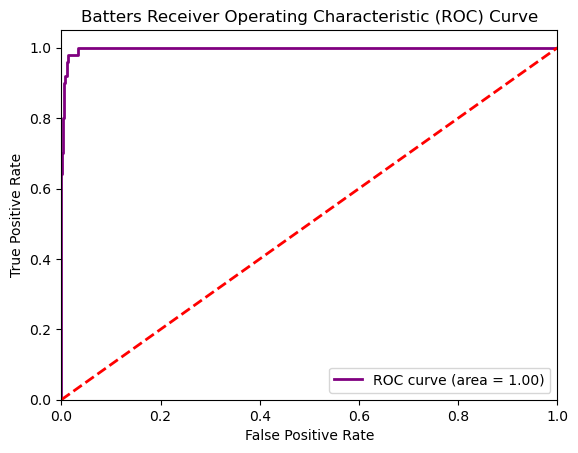

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calculate the ROC curve and area under the curve
y_prob = clf_lr_batters.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='purple', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Batters Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Next we repeat the training process over again for pitchers and their unique feature set.

In [10]:
#For pitchers
X = df_pitchingcareer[['W', 'L', 'G', 'GS', 'CG', 'SHO', 'SV', 'IPouts', 'H', 'ER', 'HR', 'BB', 'SO', 'BAOpp', 'ERA']].values
y = df_pitchingcareer['Hall of Fame'].values

seed = 42
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.35, random_state = seed)

#Oversample due to unbalanced dataset
#OverSampler = RandomOverSampler(random_state=45)
#X_Over, y_Over = OverSampler.fit_resample(X_train, y_train)

clf_lr_pitchers = LogisticRegression(random_state=0, max_iter = 10000)
clf_lr_pitchers.fit(X_train, y_train)

# Prediction
y_pred = clf_lr_pitchers.predict(X_test)

y_predP = clf_lr_pitchers.predict(X)

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix: \n", cm)

acc = accuracy_score(y_test, y_pred)
print("\nLogistic Regression model accuracy percent: ", acc)
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1 Score:', f1_score(y_test, y_pred))

Confusion Matrix: 
 [[2618    2]
 [   8   20]]

Logistic Regression model accuracy percent:  0.9962235649546828
Precision: 0.9090909090909091
Recall: 0.7142857142857143
F1 Score: 0.8


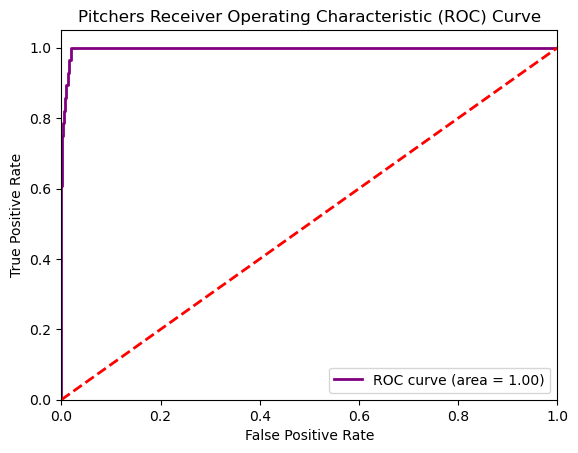

In [11]:
# Calculate the ROC curve and area under the curve
y_prob = clf_lr_pitchers.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='purple', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Pitchers Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Training a Random Forest Classifier

In order to make sure we are training the best model, we will also train a Random Forest and SVM model to make sure they perform roughly in line with the Logistic Regression model.

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

#For batters
X = df_battingcareer[['G', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH', 'SF', 'GIDP']].values
y= df_battingcareer['Hall of Fame'].values

seed = 26
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.35, random_state = seed)

# Create random forest classifier object
randomforest = RandomForestClassifier(class_weight="balanced", random_state = seed, n_jobs=-1)

# Train model
clf_rf_batters = randomforest.fit(X_train, y_train)

# Test accuracy
y_pred = clf_rf_batters.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix: \n", cm)

acc = accuracy_score(y_test, y_pred)
print("\nRandom Forest model accuracy percent: ", acc)
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1 Score:', f1_score(y_test, y_pred))

Confusion Matrix: 
 [[5504    7]
 [  25   28]]

Random Forest model accuracy percent:  0.9942487419122933
Precision: 0.8
Recall: 0.5283018867924528
F1 Score: 0.6363636363636364


# Training a SVM Model

In [13]:
from sklearn.svm import SVC

#For batters
X = df_battingcareer[['G', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH', 'SF', 'GIDP']].values
y = df_battingcareer['Hall of Fame'].values

seed = 26
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.35, random_state = seed)

#Oversample due to unbalanced dataset
#OverSampler = RandomOverSampler(random_state=45)
#X_train, y_train = OverSampler.fit_resample(X_train, y_train)

clf_svm_batters = SVC(kernel='linear', random_state=22)

clf_svm_batters.fit(X_train, y_train)

# Prediction
y_pred = clf_svm_batters.predict(X_test)

y_predP = clf_svm_batters.predict(X)

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix: \n", cm)

acc = accuracy_score(y_test, y_pred)
print("\nSVM model accuracy percent: ", acc)
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1 Score:', f1_score(y_test, y_pred))

Confusion Matrix: 
 [[5497   14]
 [  22   31]]

SVM model accuracy percent:  0.9935298346513299
Precision: 0.6888888888888889
Recall: 0.5849056603773585
F1 Score: 0.6326530612244898


By training alternative models like Random Forest and SVM, we see that we are not lossing any significant amount of fidelity by using Logistic Regression for our predictions.

# Making predictions on all eligible players

To analysis players we will add a couple of rows to our dataframe, the yes/no prediction given by our best model and the over probability that the model gives for their Hall of Fame chances.

In [14]:
#Prediction Batters
clf = clf_lr_batters

all_players_set = df_battingcareer[['G', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH', 'SF', 'GIDP']].values
X_prob = clf.predict_proba(all_players_set)
positive_prob = [array[1] for array in X_prob]
df_battingcareer["Hall of Fame Probability"] = positive_prob

X_pred = clf.predict(all_players_set)
df_battingcareer["Hall of Fame Prediction"] = X_pred

df_battingcareer.head()

#Prediction Pitchers
clf = clf_lr_pitchers

all_players_set = df_pitchingcareer[['W', 'L', 'G', 'GS', 'CG', 'SHO', 'SV', 'IPouts', 'H', 'ER', 'HR', 'BB', 'SO', 'BAOpp', 'ERA']].values
X_prob = clf.predict_proba(all_players_set)
positive_prob = [array[1] for array in X_prob]
df_pitchingcareer["Hall of Fame Probability"] = positive_prob

X_pred = clf.predict(all_players_set)
df_pitchingcareer["Hall of Fame Prediction"] = X_pred

df_pitchingcareer.head()


,playerID,W,L,G,GS,CG,SHO,SV,IPouts,H,...,BK,BFP,GF,R,SH,SF,GIDP,Hall of Fame,Hall of Fame Probability,Hall of Fame Prediction
0,aasedo01,66,60,448,91,22,5,82,3328,1085,...,3,4730.0,235,503,50.0,34.0,106.0,0.0,3.081539e-07,0.0
1,abbeybe01,22,40,79,65,52,0,1,1704,686,...,0,2568.0,14,442,0.0,0.0,0.0,0.0,6.201025e-09,0.0
2,abbeych01,0,0,1,0,0,0,0,6,6,...,0,12.0,1,3,0.0,0.0,0.0,0.0,3.954106e-09,0.0
3,abbotda01,0,2,3,1,1,0,1,39,19,...,0,67.0,2,14,0.0,0.0,0.0,0.0,4.451939e-09,0.0
4,abbotgl01,62,83,248,206,37,5,0,3858,1405,...,5,5508.0,13,707,60.0,39.0,111.0,0.0,1.688523e-09,0.0


# False Postives and False Negative

Next is a list of the the players by name that turn up as false negatives or false positives according to our model. This is mostly useful to see if we can make any observations about the players the the model struggles to classify.

In [15]:
df_false_positives = df_battingcareer[(df_battingcareer['Hall of Fame'] == 0) & (df_battingcareer['Hall of Fame Prediction'] == 1)]
player_ids = df_false_positives['playerID'].tolist()
print("False positive batters: ")
for player in player_ids:
    print(bhf.name_lookup(player,df_bio))
    
df_false_positives.head(30)

False positive batters: 
Moises Rojas Alou
Roger Maxwell Cramer
Lafayette Napoleon Cross
William Frederick Dahlen
Jacob Ellsworth Daubert
Robert Irving Elliott
Dwight Michael Evans
Luis Emilio Gonzalez
William Ellsworth Hoy
Robert Lee Johnson
Joseph Ignatius Judge
Sherwood Robert Magee
John Phalen McInnis
Albert Oliver
James Edward Ryan
Samuel James Tilden Sheckard
Daniel Joseph Staub
Frederick Tenney
Michael Joseph Tiernan
Joseph Paul Torre
George Edward Martin Van Haltren
Robert Hayes Veach
James Barton Vernon
Bernabe Williams


,playerID,G,AB,R,H,2B,3B,HR,RBI,SB,...,BB,SO,IBB,HBP,SH,SF,GIDP,Hall of Fame,Hall of Fame Probability,Hall of Fame Prediction
203,aloumo01,1942,7037,1109,2134,421,39,332,1287.0,106.0,...,737,894.0,91.0,48.0,9.0,82.0,195.0,0.0,0.563812,1.0
2984,cramedo01,2239,9140,1357,2705,396,109,37,842.0,62.0,...,572,345.0,0.0,41.0,180.0,0.0,99.0,0.0,0.558356,1.0
3071,crossla01,2277,9084,1338,2651,411,136,47,1378.0,303.0,...,466,217.0,0.0,31.0,160.0,0.0,0.0,0.0,0.585526,1.0
3202,dahlebi01,2444,9036,1590,2461,413,163,84,1234.0,548.0,...,1064,759.0,0.0,140.0,165.0,0.0,0.0,0.0,0.674118,1.0
3288,daubeja01,2014,7673,1117,2326,250,165,56,722.0,251.0,...,623,489.0,0.0,54.0,392.0,0.0,0.0,0.0,0.882824,1.0
4092,elliobo01,1978,7141,1064,2061,382,94,170,1195.0,60.0,...,967,604.0,0.0,16.0,66.0,0.0,187.0,0.0,0.609920,1.0
4241,evansdw01,2606,8996,1470,2446,483,73,385,1384.0,78.0,...,1391,1697.0,60.0,53.0,52.0,77.0,227.0,0.0,0.594671,1.0
5310,gonzalu01,2591,9157,1412,2591,596,68,354,1439.0,128.0,...,1155,1218.0,150.0,111.0,10.0,98.0,212.0,0.0,0.684885,1.0
6695,hoydu01,1797,7115,1429,2048,248,121,40,725.0,596.0,...,1006,345.0,0.0,134.0,130.0,0.0,0.0,0.0,0.662363,1.0
7044,johnsbo01,1863,6920,1239,2051,396,95,288,1283.0,96.0,...,1075,851.0,0.0,24.0,28.0,0.0,102.0,0.0,0.743910,1.0


In [16]:
df_false_positives = df_pitchingcareer[(df_pitchingcareer['Hall of Fame'] == 0) & (df_pitchingcareer['Hall of Fame Prediction'] == 1)]
player_ids = df_false_positives['playerID'].tolist()
print("False positive pitchers: ")
for player in player_ids:
    print(bhf.name_lookup(player,df_bio))
    
df_false_positives.head(30)

False positive pitchers: 
Charles Benjamin Adams
Thomas Henry Bond
Carl William Mays
Anthony John Mullane
Allie Pierce Reynolds
Curtis Montague Schilling
James Robert Shawkey
Albert Goodwill Spalding


,playerID,W,L,G,GS,CG,SHO,SV,IPouts,H,...,BK,BFP,GF,R,SH,SF,GIDP,Hall of Fame,Hall of Fame Probability,Hall of Fame Prediction
26,adamsba01,194,140,482,355,206,44,15,8986,2841,...,2,11947.0,89,1129,0.0,0.0,0.0,0.0,0.884910,1.0
596,bondto01,234,163,417,408,386,42,0,10886,3765,...,0,15082.0,13,1931,0.0,0.0,0.0,0.0,0.774707,1.0
4348,maysca01,207,126,490,325,231,29,31,9064,2912,...,1,12385.0,125,1211,0.0,0.0,0.0,0.0,0.624223,1.0
4840,mullato01,284,220,555,504,468,30,15,13594,4195,...,3,19407.0,52,2523,0.0,0.0,0.0,0.0,0.770967,1.0
5677,reynoal01,182,107,434,309,137,36,49,7477,2193,...,6,10660.0,97,1026,0.0,0.0,0.0,0.0,0.561934,1.0
6040,schilcu01,216,146,569,436,83,20,22,9783,2998,...,8,13284.0,81,1318,123.0,76.0,193.0,0.0,0.708459,1.0
6185,shawkbo01,196,150,488,334,197,33,28,8811,2722,...,1,12074.0,113,1200,0.0,0.0,0.0,0.0,0.515265,1.0
6404,spaldal01,251,65,347,325,279,24,13,8659,3280,...,2,12724.0,31,1790,0.0,0.0,0.0,0.0,0.925311,1.0


In [17]:
df_false_negatives = df_battingcareer[(df_battingcareer['Hall of Fame'] == 1) & (df_battingcareer['Hall of Fame Prediction'] == 0)]
player_ids = df_false_negatives['playerID'].tolist()
print("False negative batters: ")
for player in player_ids:
    print(bhf.name_lookup(player,df_bio))
    
df_false_negatives.head(35)

False negative batters: 
Luis Ernesto Aparicio
John Franklin Baker
David James Bancroft
Johnny Lee Bench
Louis Boudreau
Roger Philip Bresnahan
Louis Clark Brock
Roy Campanella
Gary Edmund Carter
Frank Leroy Chance
Gordon Stanley Cochrane
James Joseph Collins
Earle Bryan Combs
William Malcolm Dickey
Lawrence Eugene Doby
John Joseph Evers
William Ewing
Richard Benjamin Ferrell
Carlton Ernest Fisk
Elmer Harrison Flick
Joseph Lowell Gordon
Charles James Hafey
Charles Leo Hartnett
Gilbert Ray Hodges
Travis Calvin Jackson
Hugh Ambrose Jennings
George Clyde Kell
George Lange Kelly
Michael Joseph Kelly
Anthony Michael Lazzeri
Frederick Charles Lindstrom
Ernesto Natali Lombardi
Walter James Vincent Maranville
William Stanley Mazeroski
Thomas Francis Michael McCarthy
Saturnino Orestes Armas Minoso
Tony Pedro Oliva
Atanacio Perez
Kirby Puckett
Harold Henry Reese
Philip Francis Rizzuto
Brooks Calbert Robinson
Jack Roosevelt Robinson
Ryne Dee Sandberg
Ronald Edward Santo
Ray William Schalk
Albert F

,playerID,G,AB,R,H,2B,3B,HR,RBI,SB,...,BB,SO,IBB,HBP,SH,SF,GIDP,Hall of Fame,Hall of Fame Probability,Hall of Fame Prediction
317,aparilu01,2601,10230,1335,2677,394,92,83,791.0,506.0,...,736,742.0,22.0,27.0,161.0,76.0,184.0,1.0,0.114072,0.0
512,bakerfr01,1575,5984,887,1838,315,103,96,987.0,235.0,...,473,268.0,0.0,50.0,153.0,0.0,0.0,1.0,0.289325,0.0
563,bancrda01,1913,7182,1048,2004,320,77,32,591.0,145.0,...,827,487.0,0.0,23.0,212.0,0.0,0.0,1.0,0.072405,0.0
916,benchjo01,2158,7658,1091,2048,381,24,389,1376.0,68.0,...,891,1278.0,135.0,19.0,11.0,90.0,201.0,1.0,0.225654,0.0
1361,boudrlo01,1646,6029,861,1779,385,66,68,789.0,51.0,...,796,309.0,0.0,34.0,164.0,0.0,155.0,1.0,0.295966,0.0
1532,bresnro01,1446,4481,682,1252,218,71,26,530.0,212.0,...,714,403.0,0.0,67.0,112.0,0.0,0.0,1.0,0.010668,0.0
1598,brocklo01,2616,10332,1610,3023,486,141,149,900.0,938.0,...,761,1730.0,124.0,49.0,47.0,46.0,114.0,1.0,0.495727,0.0
2046,camparo01,1215,4205,627,1161,178,18,242,856.0,25.0,...,533,501.0,30.0,30.0,30.0,18.0,143.0,1.0,0.062750,0.0
2197,cartega01,2296,7971,1025,2092,371,31,324,1225.0,39.0,...,848,997.0,106.0,68.0,33.0,99.0,180.0,1.0,0.081478,0.0
2337,chancfr01,1288,4299,798,1274,200,79,20,596.0,403.0,...,556,320.0,0.0,137.0,111.0,0.0,0.0,1.0,0.038766,0.0


In [18]:
df_false_negatives = df_pitchingcareer[(df_pitchingcareer['Hall of Fame'] == 1) & (df_pitchingcareer['Hall of Fame Prediction'] == 0)]
player_ids = df_false_negatives['playerID'].tolist()
print("False negative pitchers: ")
for player in player_ids:
    print(bhf.name_lookup(player,df_bio))
    
df_false_negatives.head(35)

False negative pitchers: 
John Dwight Chesbro
Jay Hanna Dean
Urban Clarence Faber
Vernon Louis Gomez
Clark Calvin Griffith
Jesse Joseph Haines
James Lee Kaat
Sanford Koufax
Robert Granville Lemon
Theodore Amar Lyons
Richard William Marquard
Harold Newhouser
Amos Wilson Rusie
Charles Arthur Vance
John Montgomery Ward


,playerID,W,L,G,GS,CG,SHO,SV,IPouts,H,...,BK,BFP,GF,R,SH,SF,GIDP,Hall of Fame,Hall of Fame Probability,Hall of Fame Prediction
1133,chesbja01,198,132,392,332,260,35,5,8690,2647,...,2,11632.0,52,1206,0.0,0.0,0.0,1.0,0.375405,0.0
1591,deandi01,150,83,317,230,154,26,30,5902,1919,...,5,8171.0,76,774,0.0,0.0,0.0,1.0,0.051093,0.0
2019,faberre01,254,213,669,483,273,29,28,12260,4106,...,2,17360.0,134,1813,0.0,0.0,0.0,1.0,0.235416,0.0
2521,gomezle01,189,102,368,320,173,28,9,7509,2290,...,0,10729.0,31,1091,0.0,0.0,0.0,1.0,0.040274,0.0
2629,griffcl01,237,146,453,372,337,22,8,10157,3670,...,3,14335.0,78,1852,0.0,0.0,0.0,1.0,0.203553,0.0
2726,haineje01,210,158,555,388,208,24,10,9626,3460,...,6,13644.0,95,1556,0.0,0.0,0.0,1.0,0.003029,0.0
3491,kaatji01,283,237,898,625,180,31,18,13591,4620,...,6,19023.0,102,2038,93.0,80.0,194.0,1.0,0.001175,0.0
3734,koufasa01,165,87,397,314,137,40,9,6973,1754,...,7,9497.0,44,806,0.0,0.0,0.0,1.0,0.008000,0.0
3942,lemonbo01,207,128,460,350,188,31,22,8550,2559,...,2,12099.0,73,1185,0.0,0.0,0.0,1.0,0.130351,0.0
4128,lyonste01,260,230,594,484,356,27,23,12483,4489,...,6,17846.0,92,2056,0.0,0.0,0.0,1.0,0.411281,0.0


# Testing Individual Players

To test active players, we will import a fresh dataframe of batters.

In [19]:
#Recompiling Career stats to include active players.
df_battingactive = pd.read_csv('./lahman_1871-2023_csv/Batting.csv', encoding='latin-1')
df_battingactive = df_battingactive.groupby('playerID', as_index=False).sum()
df_battingactive.drop(df_battingactive[["yearID","stint","teamID","lgID","G_batting", "G_old"]], axis=1, inplace=True)

Let's return to Chase Utley and see what our model predicts he as.

In [20]:
#Testing Chase Utley
clf = clf_lr_batters
player_to_find = 'utleych01'
matching_row = df_battingactive.loc[df_battingactive['playerID'] == player_to_find]
print(matching_row)

player_to_test = df_battingactive.iloc[matching_row.index]
X_test = player_to_test[['G', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH', 'SF', 'GIDP']].values
prediction_precent = clf.predict_proba(X_test)
print('Probabilities:', prediction_precent)
prediction = clf.predict(X_test)
print('Prediction:', prediction)



        playerID     G    AB     R     H   2B  3B   HR     RBI     SB    CS  \
19053  utleych01  1937  6857  1103  1885  411  58  259  1025.0  154.0  22.0   

        BB      SO   IBB    HBP   SH    SF  GIDP  
19053  724  1193.0  62.0  204.0  6.0  72.0  93.0  
Probabilities: [[0.97103631 0.02896369]]
Prediction: [0.]


So according to our model Utley falls well short of the Hall of Fame.

# Testing Rickey Henderson's Career

The all-time MLB Stolen Base king, Rickey Henderson, had such a good career that the baseball writer Bill James famously wrote, "If you could split him in half you'd have two Hall of Famers." Next we will put this to the test, and place half of Henderson's career stats into out model. 

In [21]:
#"If you could split him in half you'd have two Hall of Famers." -Bill James
clf = clf_lr_batters
player_to_find = 'henderi01'
matching_row = df_battingcareer.loc[df_battingcareer['playerID'] == player_to_find]
print(matching_row)

player_to_test = df_battingcareer.iloc[matching_row.index]
X_test = X = player_to_test[['G', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH', 'SF', 'GIDP']].values
Half_a_Henderson = X_test/2
prediction_precent = clf.predict_proba(Half_a_Henderson)
print('\nPrediction on Half a Henderson:\n')
print('Probabilities:', prediction_precent)
prediction = clf.predict(Half_a_Henderson)
print('Prediction:', prediction)
        

       playerID     G     AB     R     H   2B  3B   HR     RBI      SB  ...  \
6173  henderi01  3081  10961  2295  3055  510  66  297  1115.0  1406.0  ...   

        BB      SO   IBB   HBP    SH    SF   GIDP  Hall of Fame  \
6173  2190  1694.0  61.0  98.0  30.0  67.0  172.0           1.0   

      Hall of Fame Probability  Hall of Fame Prediction  
6173                  0.991786                      1.0  

[1 rows x 21 columns]

Prediction on Half a Henderson:

Probabilities: [[0.91102787 0.08897213]]
Prediction: [0.]


Purhaps not surprisingly, half of Rickey Henderson's career is not literally a Hall of Famer (although he does get a respectable percent). But that raises a question, what percentage of Henderson's career would make him a Hall of Famer?

In [22]:
one_percent_of_henderson = Half_a_Henderson / 100
candidate = Half_a_Henderson
iterations = 0
current_prediction = 0
while(current_prediction == 0 and iterations < 150):
    iterations = iterations + 1
    candidate = candidate + one_percent_of_henderson
    current_prediction = clf.predict(candidate)
print("It would take %", 50+iterations,  "of Rickey Henderson to make the Hall of Fame.")

It would take % 83 of Rickey Henderson to make the Hall of Fame.


Using a while loop to add %1 percent of his career stats for each iteration, we see that 0.83 of Rickey Henderson is a Hall of Famer.

So is there any player who you could split in two and get two Hall of Famers? Lets look at the all-time homerun king Barry Bonds  to test. (Note: Splitting him in two might actually help his chances because in real life the whole Barry Bonds is not in the Hall due to steriod use.)

In [23]:
#Testing Barry Bonds
clf = clf_lr_batters
player_to_find = 'bondsba01'
matching_row = df_battingactive.loc[df_battingactive['playerID'] == player_to_find]
print(matching_row)

player_to_test = df_battingcareer.iloc[matching_row.index]
X_test = X = player_to_test[['G', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH', 'SF', 'GIDP']].values
Half_a_Bonds = X_test/2
prediction_precent = clf.predict_proba(Half_a_Bonds)
print('\nPrediction on Half a Bonds:\n')
print('Probabilities:', prediction_precent)
prediction = clf.predict(Half_a_Bonds)
print('Prediction:', prediction)
        

       playerID     G    AB     R     H   2B  3B   HR     RBI     SB     CS  \
1715  bondsba01  2986  9847  2227  2935  601  77  762  1996.0  514.0  141.0   

        BB      SO    IBB    HBP   SH    SF   GIDP  
1715  2558  1539.0  688.0  106.0  4.0  91.0  165.0  

Prediction on Half a Bonds:

Probabilities: [[0.99686388 0.00313612]]
Prediction: [0.]


So even Barry Bonds is not good enought to literally be a Hall of Famer if split in two.

# Worst Hall of Famer & Best Non-Hall of Famer

By comparing the Hall of Fame Probability given by the logistic regression model, we will determine who are the best pitchers/hitters not in the Hall and vice versa.

In [24]:
df_nonhallers = df_battingcareer[df_battingcareer['Hall of Fame'] == 0]
max_probability_row = df_nonhallers.loc[df_nonhallers['Hall of Fame Probability'].idxmax()]
best_non_haller = max_probability_row['playerID']
print("The best position player not in the Hall is:", bhf.name_lookup(best_non_haller, df_bio))


The best position player not in the Hall is: George Edward Martin Van Haltren


In [25]:
df_nonhallers = df_pitchingcareer[df_pitchingcareer['Hall of Fame'] == 0]
max_probability_row = df_nonhallers.loc[df_nonhallers['Hall of Fame Probability'].idxmax()]
best_non_haller = max_probability_row['playerID']
print("The best pitcher not in the Hall is:", bhf.name_lookup(best_non_haller, df_bio))

The best pitcher not in the Hall is: Albert Goodwill Spalding


Note that Al Spalding is a bit of an outlier here since he actually IS in the Hall. However he was inducted as an executive so he did not meet the requirements of our original query. But it is seems certain that his career as a pitcher has Hall worthy.

In [26]:
df_hallers = df_battingcareer[df_battingcareer['Hall of Fame'] == 1]
min_probability_row = df_hallers.loc[df_hallers['Hall of Fame Probability'].idxmin()]
worst_haller = min_probability_row['playerID']
print("The worst postion player in the Hall is:", bhf.name_lookup(worst_haller, df_bio))

The worst postion player in the Hall is: Ray William Schalk


In [27]:
df_hallers = df_pitchingcareer[df_pitchingcareer['Hall of Fame'] == 1]
min_probability_row = df_hallers.loc[df_hallers['Hall of Fame Probability'].idxmin()]
worst_haller = min_probability_row['playerID']
print("The worst pitcher in the Hall is:", bhf.name_lookup(worst_haller, df_bio))

The worst pitcher in the Hall is: James Lee Kaat


# Seperating Players by Position

Looking at our prediction for Chase Utley, it is a little surprising that he did so poorly.  In real life, while not guarenteed to be elected, he has a much stronger chance. A problem with our model is that is agnostic to postion, it treats postion players the same no matter their actual postion. This is a simplification as players will get credit from voters for playing more defensively demanding postions (like catcher and shortstop). Utley played an important postion (second baseman) so perhaps limiting the model to only his postional peers will create a better model.

In [28]:
df_fielding = pd.read_csv('./lahman_1871-2023_csv/Fielding.csv', encoding='latin-1')
df_fielding.drop(df_fielding[["yearID","stint","teamID","lgID"]], axis=1, inplace=True)

df_fielding = bhf.find_career_fielding_stats(df_fielding)
df_fielding.head()
df_battingcareer.insert(1, 'POS', df_battingcareer['playerID'].apply(lambda playerID: bhf.find_primary_postion(playerID, df_fielding)))


In [29]:
df_battingcareer2B = df_battingcareer[df_battingcareer['POS'] == '2B']
df_battingcareer2Bhof = df_battingcareer2B[df_battingcareer2B['Hall of Fame'] == 1]
df_battingcareer2Bhof.head(5)

,playerID,POS,G,AB,R,H,2B,3B,HR,RBI,...,BB,SO,IBB,HBP,SH,SF,GIDP,Hall of Fame,Hall of Fame Probability,Hall of Fame Prediction
197,alomaro01,2B,2379,9073,1508,2724,504,80,210,1134.0,...,1032,1140.0,62.0,50.0,148.0,97.0,206.0,1.0,0.865050,1.0
1067,biggicr01,2B,2850,10876,1844,3060,668,55,291,1175.0,...,1160,1753.0,68.0,285.0,101.0,81.0,150.0,1.0,0.633643,1.0
2685,collied01,2B,2826,9949,1821,3315,438,187,47,1300.0,...,1499,400.0,0.0,77.0,512.0,0.0,0.0,1.0,0.999963,1.0
3677,doerrbo01,2B,1865,7093,1094,2042,381,89,223,1247.0,...,809,608.0,0.0,11.0,115.0,0.0,182.0,1.0,0.758991,1.0
4253,eversjo01,2B,1784,6137,919,1659,216,70,12,538.0,...,778,293.0,0.0,39.0,256.0,0.0,0.0,1.0,0.099432,0.0


In [30]:
#For Second Baseman

X = df_battingcareer2B[['G', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH', 'SF', 'GIDP']].values
y = df_battingcareer2B['Hall of Fame'].values

seed = 2
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30, random_state = seed)

clf_lr_secondbase = LogisticRegression(random_state=seed, max_iter = 10000)
clf_lr_secondbase.fit(X_train, y_train)

# Prediction
y_pred = clf_lr_secondbase.predict(X_test)

y_predP = clf_lr_secondbase.predict(X)

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix: \n", cm)

acc = accuracy_score(y_test, y_pred)
print("\n2B Random Forest model accuracy percent: ", acc)
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1 Score:', f1_score(y_test, y_pred))

Confusion Matrix: 
 [[301   1]
 [  1   5]]

2B Random Forest model accuracy percent:  0.9935064935064936
Precision: 0.8333333333333334
Recall: 0.8333333333333334
F1 Score: 0.8333333333333334


Now that having a model that is narrowly focused on second baseman, let's test it with Utley again to see if he fares better.

In [31]:
clf = clf_lr_secondbase
player_to_find = 'utleych01'
matching_row = df_battingactive.loc[df_battingactive['playerID'] == player_to_find]
print(matching_row)

player_to_test = df_battingactive.iloc[matching_row.index]
X_test = player_to_test[['G', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH', 'SF', 'GIDP']].values
prediction_precent = clf.predict_proba(X_test)
print('Probabilities:', prediction_precent)
prediction = clf.predict(X_test)
print('Prediction:', prediction)

        playerID     G    AB     R     H   2B  3B   HR     RBI     SB    CS  \
19053  utleych01  1937  6857  1103  1885  411  58  259  1025.0  154.0  22.0   

        BB      SO   IBB    HBP   SH    SF  GIDP  
19053  724  1193.0  62.0  204.0  6.0  72.0  93.0  
Probabilities: [[1.00000000e+00 1.49931138e-13]]
Prediction: [0.]


Even if we limit our data to second baseman Utley's probability does not improve, probably due to overfitting in our model.

# Training a Ballot Classifier

So far we have look at Hall of Fame status as a simple yes or no, but this leaves off a lot of detail for how we usual approach this conversion. Since players can appear on the ballot a maximum of ten times, baseball fans often talk about a "First Ballot Hall of Famer" as the very best players to seperate them from players who need more ballots to get in. In this next portion we will bucket players into groups based on how many times they appeared on the ballot.

In [32]:
def check_ballot_status(df_players, df_halloffame):
    # Initialize the new column in the first dataframe
    df_players['Ballot Status'] = ''

    # Iterate through each row in the first dataframe
    for index, row in df_players.iterrows():
        player_id = row['playerID']
        occurrences = df_halloffame[df_halloffame['playerID'] == player_id].shape[0]
        elected = (df_halloffame[(df_halloffame['playerID'] == player_id) & (df_halloffame['inducted'] == 'Y')].shape[0] > 0)

        # Update 'Ballot Status' based on the occurrences and elected status
        if occurrences == 0:
            df_players.at[index, 'Ballot Status'] = 'Not in Hall'
        elif occurrences == 1:
            if elected == True:
                df_players.at[index, 'Ballot Status'] = 'First Ballot Hall of Famer'
            else:
                df_players.at[index, 'Ballot Status'] = 'First Ballot Off Ballot'
        elif occurrences == 2:
            if elected == True:
                df_players.at[index, 'Ballot Status'] = 'Second Ballot Hall of Famer'
            else:
                df_players.at[index, 'Ballot Status'] = 'Early Off Ballot'
        elif occurrences == 3:
            if elected == True:
                df_players.at[index, 'Ballot Status'] = 'Early Ballot Hall of Famer'
            else:
                df_players.at[index, 'Ballot Status'] = 'Early Off Ballot'
        elif occurrences == 4:
            if elected == True:
                df_players.at[index, 'Ballot Status'] = 'Early Ballot Hall of Famer'
            else:
                df_players.at[index, 'Ballot Status'] = 'Early Off Ballot'
        elif occurrences == 5:
            if elected == True:
                df_players.at[index, 'Ballot Status'] = 'Early Ballot Hall of Famer'
            else:
                df_players.at[index, 'Ballot Status'] = 'Early Off Ballot'
        elif occurrences == 6:
            if elected == True:
                df_players.at[index, 'Ballot Status'] = 'Late Ballot Hall of Famer'
            else:
                df_players.at[index, 'Ballot Status'] = 'Late Off Ballot'
        elif occurrences == 7:
            if elected == True:
                df_players.at[index, 'Ballot Status'] = 'Late Ballot Hall of Famer'
            else:
                df_players.at[index, 'Ballot Status'] = 'Late Off Ballot'
        elif occurrences == 8:
            if elected == True:
                df_players.at[index, 'Ballot Status'] = 'Late Ballot Hall of Famer'
            else:
                df_players.at[index, 'Ballot Status'] = 'Late Off Ballot'
        elif occurrences == 9:
            if elected == True:
                df_players.at[index, 'Ballot Status'] = 'Late Ballot Hall of Famer'
            else:
                df_players.at[index, 'Ballot Status'] = 'Late Off Ballot'
        elif occurrences == 10:
            if elected == True:
                df_players.at[index, 'Ballot Status'] = 'Late Ballot Hall of Famer'
            else:
                df_players.at[index, 'Ballot Status'] = 'Aged Off Ballot'
        elif occurrences >= 10:
            if elected == True:
                df_players.at[index, 'Ballot Status'] = 'Elected Hall of Famer (Other Means)'
            else:
                df_players.at[index, 'Ballot Status'] = 'Aged Off Ballot'
        else:
            df_players.at[index, 'Ballot Status'] = f'Not Elected, Occurrences: {occurrences}'

    return df_players
            
    

In [33]:
df_cleanhall = pd.read_csv('./lahman_1871-2023_csv/HallOfFame.csv')
df_cleanhall = df_cleanhall.query("category == 'Player' and needed_note != 'Preliminary poll'")

df_battingcareernew = df_batting.groupby('playerID', as_index=False).sum()
df_battingcareernew.drop(df_battingcareernew[["yearID","stint","teamID","lgID","G_batting", "G_old"]], axis=1, inplace=True)

df_battingcareernew = check_ballot_status(df_battingcareernew, df_cleanhall)
#df_battingcareernew = df_battingcareer[df_battingcareer['Ballot Status'] != 'Not in Hall']
df_battingcareernew.head()

,playerID,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,Ballot Status
0,aaronha01,3298,12364,2174,3771,624,98,755,2297.0,240.0,73.0,1402,1383.0,293.0,32.0,21.0,121.0,328.0,First Ballot Hall of Famer
1,aaronto01,437,944,102,216,42,6,13,94.0,9.0,8.0,86,145.0,3.0,0.0,9.0,6.0,36.0,Not in Hall
2,aasedo01,448,5,0,0,0,0,0,0.0,0.0,0.0,0,3.0,0.0,0.0,0.0,0.0,0.0,Not in Hall
3,abadan01,15,21,1,2,0,0,0,0.0,0.0,1.0,4,5.0,0.0,0.0,0.0,0.0,1.0,Not in Hall
4,abadijo01,12,49,4,11,0,0,0,5.0,1.0,0.0,0,3.0,0.0,0.0,0.0,0.0,0.0,Not in Hall


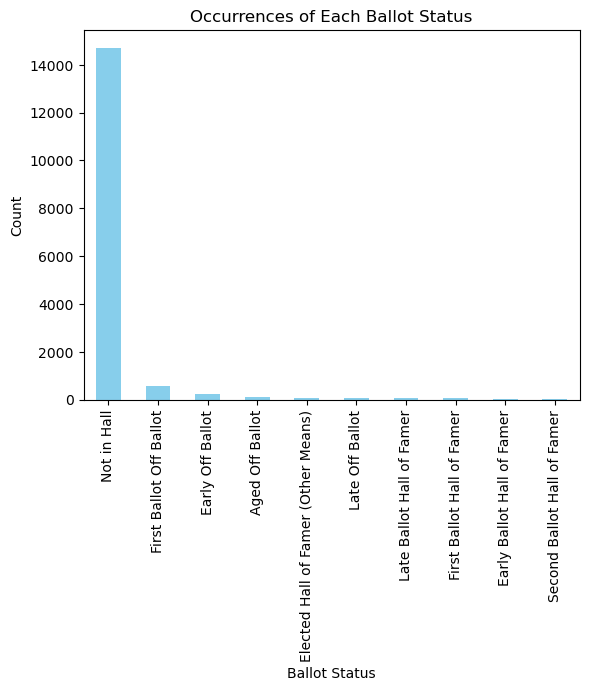

In [34]:
import matplotlib.pyplot as plt

status_counts = df_battingcareernew['Ballot Status'].value_counts()

# Create the histogram
status_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Ballot Status')
plt.ylabel('Count')
plt.title('Occurrences of Each Ballot Status')
plt.xticks(rotation=90)
plt.show()

# Use A Random Forest Classifier for Ballot Status

Next we will train a Random Forest classifier to using ballot status as the target feature.

In [35]:
# Load libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Load data
X = df_battingcareernew[['G', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH', 'SF', 'GIDP']].values
y= df_battingcareernew['Ballot Status'].values

seed = 55
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state = seed)

# Create random forest classifier object
randomforest = RandomForestClassifier(random_state=0, n_jobs=-1)

# Train model
model = randomforest.fit(X_train, y_train)

# Test accuracy
y_preds = model.predict(X_test)

acc = accuracy_score(y_test, y_preds)
print("Logistic Regression model accuracy percent: ", acc*100)

cm = confusion_matrix(y_test, y_preds)
print("Confusion Matrix: \n", cm)

Logistic Regression model accuracy percent:  93.1806743834927
Confusion Matrix: 
 [[   1    1    2    0    0    2    3    0   12    0]
 [   0    0    1    1    0    1    1    0    3    0]
 [   3    0    6    2    0   11    0    1   38    0]
 [   1    1    2    4    0    1    2    0    7    0]
 [   0    1    0    0    7    1    3    0    3    1]
 [   1    0    4    0    0   35    1    0  110    0]
 [   0    1    0    0    0    2    3    0    8    0]
 [   0    0    4    2    0    2    1    0   12    0]
 [   0    0    3    0    0   11    1    0 3647    0]
 [   0    1    0    0    0    0    1    0    1    0]]


In [36]:
#Predict the status of Chase Utley
#Testing Chase Utley
clf = model
player_to_find = 'utleych01'
matching_row = df_battingactive.loc[df_battingactive['playerID'] == player_to_find]
print(matching_row)

player_to_test = df_battingactive.iloc[matching_row.index]
X_test = player_to_test[['G', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH', 'SF', 'GIDP']].values
prediction = clf.predict(X_test)
print('Prediction:', prediction)

        playerID     G    AB     R     H   2B  3B   HR     RBI     SB    CS  \
19053  utleych01  1937  6857  1103  1885  411  58  259  1025.0  154.0  22.0   

        BB      SO   IBB    HBP   SH    SF  GIDP  
19053  724  1193.0  62.0  204.0  6.0  72.0  93.0  
Prediction: ['First Ballot Off Ballot']


So our model predicts that Utley will appear on the Hall of Fame ballot once before falling off, a bar that he has already cleared in real life.

# Conclusions

Looking at the players that form our set of false negative and false positives, we can see a couple of limitations of our model. The first of which we already examined is that it does not account for the different defensive postions that postion players are, although sorting by postions would most likely leave our training set too small. Another is that the real Hall of Famer rewards players that have really great peaks, the real Hall is much more likely to induct a player who was the best player in baseball for a number of years than our model which rewards longevity and sustained if unspectactular performance. If we ran another iteriation of the model it would be interesting to include the number of yearly awards won to try to better capture a players peak. And finally the model does not account for different eras that a player plays in, the model does not adjust for this but the voters certainly do.

Ultimately our model experiement shows why a Machine Learning model will never replace the writers who vote on the Hall of Fame.  It is impossible to incorporate the human element of baseball and sports in a ML model, but it does reveal interesting differences in the models and writers priorities and players from the past that may have been overlooked.

# Resources

Lahman Database: <br>
http://www.seanlahman.com/<br>
    
Baseball Reference:<br>
https://www.baseball-reference.com